In [1]:
import huggingface_hub
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

import os
from dotenv import load_dotenv
from collections import defaultdict

In [2]:
load_dotenv(".env")

True

In [3]:
def load(data_path, split):
        res = list()
        with open(os.path.join(data_path, f'{split}_text.txt'), encoding="utf-8") as f:
            text = f.readlines()
        
        with open(os.path.join(data_path, f'{split}_labels.txt'), encoding="utf-8") as f:
            labels = f.readlines()

        for i, (t, l) in enumerate(zip(text, labels)):
            res.append({
                "text": t,
                "label": int(l.strip())
            })
        return res

In [ ]:
huggingface_hub.login(os.environ["HFTOKEN"])

In [5]:
# dataset = load_dataset()
# "label", "text"
DATAPATH = r"..\tweeteval-emotion_recognition\data"
train_data = load(DATAPATH,"train")
val_data = load(DATAPATH,"val")
test_data = load(DATAPATH,"test")

with open(os.path.join(DATAPATH, "mapping.txt")) as f:
    id2label = {int(line.split()[0]): line.split()[1] for line in f}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
# 66_956_548 parameters
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id={label: id for id, label in id2label.items()}
)

# Parameters
model.num_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


66956548

In [9]:
import numpy as np

accuracy = evaluate.load("accuracy")

def tokenize(data):
    texts, labels = zip(*[(d["text"], d["label"]) for d in data])
    texts = tokenizer(list(texts), truncation=True, padding=True)
    return [{"input_ids": text, "label": label} for text, label in zip(texts["input_ids"], labels)]

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
tokenized_train_data = tokenize(train_data)
tokenized_val_data = tokenize(val_data)
tokenized_test_data = tokenize(test_data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [11]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.7907089591026306, 'eval_accuracy': 0.732620320855615, 'eval_runtime': 0.3852, 'eval_samples_per_second': 970.946, 'eval_steps_per_second': 62.307, 'epoch': 1.0}


  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.6412944197654724, 'eval_accuracy': 0.7834224598930482, 'eval_runtime': 0.372, 'eval_samples_per_second': 1005.324, 'eval_steps_per_second': 64.513, 'epoch': 2.0}
{'train_runtime': 28.5691, 'train_samples_per_second': 228.009, 'train_steps_per_second': 14.281, 'train_loss': 0.8976575814041436, 'epoch': 2.0}


TrainOutput(global_step=408, training_loss=0.8976575814041436, metrics={'train_runtime': 28.5691, 'train_samples_per_second': 228.009, 'train_steps_per_second': 14.281, 'total_flos': 104494631894688.0, 'train_loss': 0.8976575814041436, 'epoch': 2.0})

In [ ]:
trainer.save_model("distilbert-base-uncased-emotion")

In [39]:
from transformers import pipeline
classifier = pipeline("text-classification", model=trainer.model, tokenizer=tokenizer)

In [48]:
import torch
model = trainer.model
texts, labels = zip(*[(d["text"], d["label"]) for d in test_data])
with torch.no_grad():
    model.eval()
    model.to("cpu")
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=1).tolist()

acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
acc

0.7762139338494018

              precision    recall  f1-score   support

       anger       0.76      0.92      0.83       558
         joy       0.77      0.84      0.80       358
    optimism       0.80      0.28      0.42       123
     sadness       0.81      0.68      0.74       382

    accuracy                           0.78      1421
   macro avg       0.79      0.68      0.70      1421
weighted avg       0.78      0.78      0.76      1421



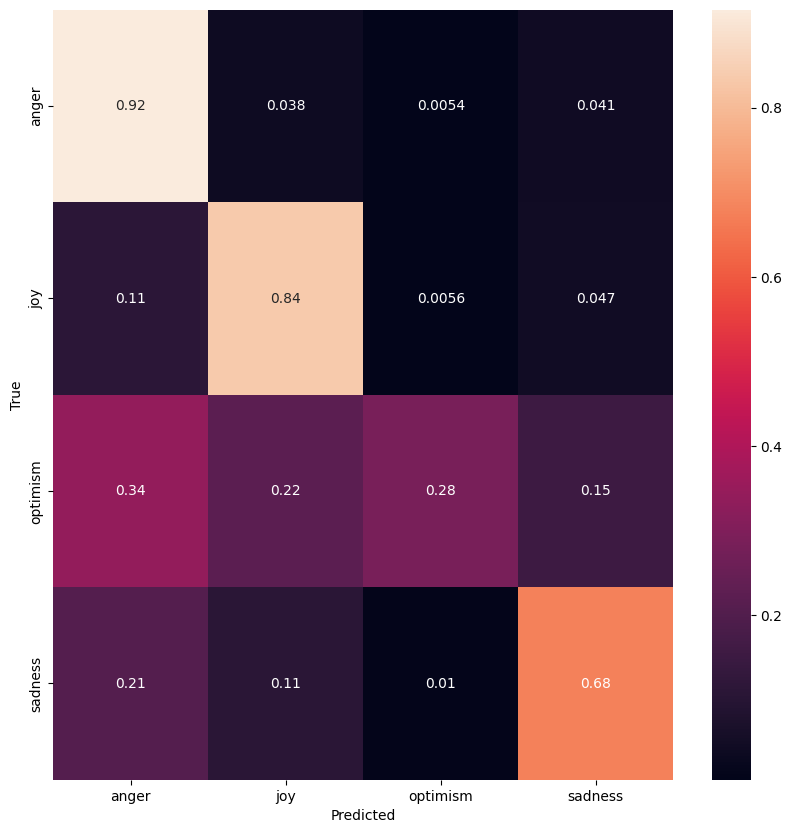

In [49]:
# Accuracy per class
from sklearn.metrics import classification_report
print(classification_report(labels, predictions, target_names=id2label.values()))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predictions, normalize="true")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

